In [1]:
import sys, os
PATH = os.path.dirname(os.path.abspath(os.curdir))
if PATH not in sys.path:
    sys.path.insert(0, PATH)

import logging

logging.basicConfig(level=logging.ERROR)
logging.getLogger("torch").setLevel(logging.ERROR)
logging.getLogger("transformers").setLevel(logging.ERROR)

from pathos.multiprocessing import ProcessPool
import src.Simulator as sim_system
import src.Optimizer as opt
import src.SimGrad as sim_diff
import scipy as sp
import numpy as np
import torch
import tqdm


###* Create Simulator object
reactions_file = "../reactions/reactionsSimpleV1.json"

const_dict = {
        "F0": 1.5e15,           # cm^-2
        "S0": 3e13,             # cm^-2
        
        "R": 0.00831442,        # kJ/mol*K
        "kBoltz": 1.380649e-23, # J/K
}

initial_state_dict = {'O_F': 0.1, 'O2_F':0.1 ,'O_S': 0.1, 'Vdb_S':0.1, 
                    'Odb_S': 0.1, 'CO_F': 0.1, 'CO2_F':0.1, 'CO_S': 0.1, 
                    'COdb_S': 0.0}

###* Functions for the data transformation
def compute_flux(const_dict, exp_dict, specie, molar_mass):
    den = exp_dict.get(specie, 0.0)
    v_th = np.sqrt((8.0 * const_dict['R'] * 1000 * exp_dict['Tnw'])/(molar_mass * np.pi))
    flux = 0.25 * v_th * den * 100
    return flux


def compute_remaining_flux(const_dict, exp_dict, molar_mass): 
    den = exp_dict['N'] - exp_dict['O'] - exp_dict['CO']
    v_th = np.sqrt((8.0 * const_dict['R'] * 1000 * exp_dict['Tnw'])/(molar_mass * np.pi))
    flux = 0.25 * v_th * den * 100
    return flux

####? EavgMB data extracted from the Booth et al. 2019 paper
p_data_exp = [0.2, 0.3, 0.4, 0.5, 0.6, 0.75, 1.5]
EavgMB_data = [1.04, 0.91, 0.87, 0.83, 0.77, 0.5, 0.001]
interpolator = sp.interpolate.interp1d(p_data_exp, EavgMB_data, kind='linear', fill_value=0.001, bounds_error=False)


transformations_exp = {
    'Tw':       lambda const_dict, exp_dict: exp_dict['Tw'] + 273.15,
    'fluxO' :   lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O', 0.016),
    'fluxO2' :  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O2', 0.032),
    'fluxO3' :  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O3', 0.048),
    'fluxC':    lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'C', 0.012),
    'fluxCO':   lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'CO', 0.028),
    'fluxCO2':  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'CO2', 0.048),
    'EavgMB':   lambda const_dict, exp_dict: interpolator(exp_dict['pressure']).item(),
    'Ion':      lambda const_dict, exp_dict: 1e14 * exp_dict["current"]
}

output_folder_path = "../Buffer_Data"
exp_data_file = "Experimental_data_CO_Jorge.hdf5"
exp_file = os.path.join(output_folder_path, exp_data_file)

sim = sim_system.Simulator(reactions_file, const_dict, exp_file, initial_state_dict, transformations_exp=transformations_exp)


  d[CO2_F]/dt = -CO2_F*r_29 + r_28*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[CO_F]/dt = -CO_F*O_F*r_34 - 0.02*CO_F*O_S*r_39 - CO_F*r_31 - CO_F*r_33 - 0.02*CO_F*r_35*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) + r_30*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[CO_S]/dt = CO_F*r_35*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) - CO_S*O_F*r_38 - CO_S*r_36 + r_32*(-CO_S - O_S - Odb_S - Vdb_S + 1.0)
  d[O2_F]/dt = -O2_F*O_F*r_15 - O2_F*r_10 - O2_F*r_12 - O2_F*r_14 + r_9*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[O_F]/dt = -CO_F*O_F*r_34 - 0.02*CO_S*O_F*r_38 - O2_F*O_F*r_15 - 2*O_F**2*r_8 - 0.02*O_F*O_S*r_7 - 0.02*O_F*Odb_S*r_27 - 0.02*O_F*Vdb_S*r_26 - O_F*r_11 - O_F*r_2 - O_F*r_4 - 0.02*O_F*r_5*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) + r_1*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[O_S]/dt = -CO_F*O_S*r_39 - O_F*O_S*r_7 + O_F*r_5*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) - O_S*r_16 - O_S*r_17 - O_S*r_37 - O_S*r_6 + r_3*(-CO_S - O_S - Odb_S - Vdb_S + 1.0)
  d[Odb_S]/dt = -O_F*Odb_S*r_27 + O_F*Vdb_S*r_26 - Odb_S*r_23 - Odb_S*r_24 - Odb

In [2]:
###* Create optimization and diff objects with the proper bounds
lower_bounds = np.array([1e-8, 1e-8, 0.0, \
                    1e-5, 1e-5, 1e-5, 1e-5, 1e-5, \
                    1e-5, 1e-5, 1e-5, 1e-5, 1e-5
                    ])

upper_bounds = np.array([5e-1, 1e-2, 30.0, \
                    1.0, 1.0, 1.0, 1.0, 1.0, \
                    1.0, 1.0, 1.0, 1.0, 1.0
                    ])

##! define parameters to optimize
def func_optimization(params, flag='numpy'):
    
    A_d, B_d, E_d, SF_1, SF_2, SF_3, SF_4, SF_5, SF_6, SF_7, SF_8, SF_9, SF_10 = params
    
    A_d = lower_bounds[0] + (upper_bounds[0] - lower_bounds[0]) * A_d
    B_d = lower_bounds[1] + (upper_bounds[1] - lower_bounds[1]) * B_d
    E_d = lower_bounds[2] + (upper_bounds[2] - lower_bounds[2]) * E_d
    
    SF_1 = lower_bounds[3] + (upper_bounds[3] - lower_bounds[3]) * SF_1
    SF_2 = lower_bounds[4] + (upper_bounds[4] - lower_bounds[4]) * SF_2
    SF_3 = lower_bounds[5] + (upper_bounds[5] - lower_bounds[5]) * SF_3
    SF_4 = lower_bounds[6] + (upper_bounds[6] - lower_bounds[6]) * SF_4
    SF_5 = lower_bounds[7] + (upper_bounds[7] - lower_bounds[7]) * SF_5
    
    SF_6 = lower_bounds[8] + (upper_bounds[8] - lower_bounds[8]) * SF_6
    SF_7 = lower_bounds[9] + (upper_bounds[9] - lower_bounds[9]) * SF_7
    SF_8 = lower_bounds[10] + (upper_bounds[10] - lower_bounds[10]) * SF_8
    SF_9 = lower_bounds[11] + (upper_bounds[11] - lower_bounds[11]) * SF_9
    SF_10 = lower_bounds[12] + (upper_bounds[12] - lower_bounds[12]) * SF_10
    
    if flag=='numpy':
        nu_d_mod = lambda T: 1e15 * (A_d + B_d * np.exp(E_d/(const_dict['R'] * T)))
    elif flag=='torch':
        nu_d_mod = lambda T: 1e15 * (A_d + B_d * torch.exp(E_d/(const_dict['R'] * T)))
    else:
        raise ValueError(f"{flag} does not exist")
    
    dict_mod_vec = [
    {"id": 2, "rate": None, "model_dict": {"nu_d": nu_d_mod}},
    {"id": 10, "rate": None, "model_dict": {"nu_d": nu_d_mod}},
    {"id": 31, "rate": None, "model_dict": {"SF": SF_2, "nu_d": nu_d_mod}},
    
    {"id": 30, "rate": None, "model_dict": {"SF": SF_1}},
    {"id": 32, "rate": None, "model_dict": {"SF": SF_3}},
    {"id": 33, "rate": None, "model_dict": {"SF": SF_4}},
    {"id": 34, "rate": None, "model_dict": {"SF": SF_5}},
    
    {"id": 35, "rate": None, "model_dict": {"SF": SF_6}},
    {"id": 36, "rate": None, "model_dict": {"SF": SF_7}},
    {"id": 37, "rate": None, "model_dict": {"SF": SF_8}},
    {"id": 38, "rate": None, "model_dict": {"SF": SF_9}},
    {"id": 39, "rate": None, "model_dict": {"SF": SF_10}},
    ]
    
    return dict_mod_vec

##! define the default parameters
params_default = []
params_default_aux = list((0.01634, 1.67e-4, 19.75, \
                1.0, 1.0, 1e-2, 1e-1, 1e-1, \
                1e-2, 1e-1, 1e-1, 1e-1, 1e-1
                ))
for idx, param in enumerate(params_default_aux):
    value = (param - lower_bounds[idx])/(upper_bounds[idx] - lower_bounds[idx])
    params_default.append(value)

params_default = tuple(params_default)

print("params_default: ", params_default)

def loss_function(exp, teo, flag='numpy'):
    
    func = ((teo-exp)**2)/(exp**2)
    if flag == 'numpy':
        return np.mean(func)
    elif flag == 'torch':
        return torch.mean(func)
    else:
        raise ValueError(f"{flag} does not exist")


optimizer = opt.Optimizer(sim, 
                        lambda params: func_optimization(params, 'numpy'), 
                        lambda exp, teo: loss_function(exp, teo, 'numpy')
                        )

diff = sim_diff.SimDiff(sim, 
                        lambda params: func_optimization(params, 'torch'),
                        params_default=params_default,
                        gamma_exp_data=sim.gamma_exp_data_arr,
                        loss_function=lambda exp, teo: loss_function(exp, teo, 'torch')
                        )


params_default:  (0.03267998065359961, 0.0166990166990167, 0.6583333333333333, 1.0, 1.0, 0.00999009990099901, 0.0999909999099991, 0.0999909999099991, 0.00999009990099901, 0.0999909999099991, 0.0999909999099991, 0.0999909999099991, 0.0999909999099991)


In [3]:


# def loss_and_grads(params, opt_object, diff_object):
#     loss_val, frac_solutions_arr, rates_arr, _, gammas_predicted_arr = opt_object.objective_function_diff(params)
#     grad_val = diff_object.objective_function_grad(params, frac_solutions_arr, rates_arr, gammas_predicted_arr)
#     # print("loss_val: ", loss_val, "grad_val: ", grad_val, "params: ", params)
#     return loss_val, grad_val.detach().numpy()[2]


# # param_vec = np.linspace(19.5, 20.5, 12)

# param_vec = np.linspace(0.673, 0.676, 12)
# for param in param_vec:
#     params = np.array(params_default)
#     params[2] = param
    
#     print(loss_and_grads(params, optimizer, diff), param)

In [4]:


def grads_wise2(params, opt_object, diff_object):
    _, frac_solutions_arr, rates_arr, _, gammas_predicted_arr = (opt_object.objective_function_diff(params))
    grad_val = diff_object.objective_function_grad_element_wise(params, frac_solutions_arr, rates_arr, gammas_predicted_arr)
    return grad_val.detach()


def create_subspacesV2(params, percent_info, opt_object, diff_object, eps = 1e-8, reg = 1e-6):

    grad_errors = -grads_wise2(params, opt_object, diff_object)
    gamma_exp = torch.tensor(
        sim.gamma_exp_data_arr, dtype=grad_errors.dtype
    ).reshape(-1, 1)
    grad_errors = grad_errors / (gamma_exp + eps)
    norms = grad_errors.norm(dim=1, keepdim=True) + eps
    G = grad_errors / norms                 
    F  = G.T @ G                            

    F_reg = F + reg * torch.eye(F.size(0), dtype=F.dtype)
    eigvals, eigvecs = torch.linalg.eigh(F_reg) # ascending
    
    idx = torch.argsort(eigvals, descending=True)
    eigvals_sorted = eigvals[idx]
    eigvecs_sorted = eigvecs[:, idx]
    
    total_mass = eigvals_sorted.sum()
    cumulative  = torch.cumsum(eigvals_sorted, dim=0)
    k = int((cumulative < percent_info * total_mass).sum().item()) + 1
    
    Vs = eigvecs_sorted[:, :k]
    Vl = eigvecs_sorted[:, k:]
    return {
        'num_components': k,
        'Vs': Vs,
        'Vl': Vl,
        'eigvals_sorted': eigvals_sorted,
        'eigvecs_sorted': eigvecs_sorted
    }



def loss_stiff_subspace(phi, opt_object, diff_object, config):
    num_components = config['num_components']
    Vs = config['Vs']
    Vl = config['Vl']
    phi0 = config['phi0']
    
    params_aux = np.dot(Vs, phi).reshape(-1) + np.dot(Vl, phi0[num_components:]).reshape(-1)
    params = tuple(np.abs(params_aux).reshape(-1))    
    
    loss_val, frac_solutions_arr, rates_arr, _, gammas_predicted_arr = opt_object.objective_function_diff(params)
    print("loss stiff: ", loss_val, "phi: ", phi)
    
    return loss_val


def loss_and_grads_stiff_subspace(phi, opt_object, diff_object, config):
    num_components = config['num_components']
    Vs = config['Vs']
    Vl = config['Vl']
    phi0 = config['phi0']
    
    params_aux = np.dot(Vs, phi).reshape(-1) + np.dot(Vl, phi0[num_components:]).reshape(-1)
    params = tuple(np.abs(params_aux).reshape(-1))    
    
    loss_val, frac_solutions_arr, rates_arr, _, gammas_predicted_arr = opt_object.objective_function_diff(params)
    grad_val = diff_object.objective_function_grad(params, frac_solutions_arr, rates_arr, gammas_predicted_arr)
    grad_val_stiff = Vs.reshape(-1) @ grad_val.detach().numpy()
    print("loss: ", loss_val, "grads: ", grad_val_stiff, "phi: ", phi)
    
    return loss_val, grad_val_stiff



def loss_sloppy_subspace(phi, opt_object, diff_object, config):
    num_components = config['num_components']
    Vs = config['Vs']
    Vl = config['Vl']
    phi0 = config['phi0']
    
    params_aux = np.dot(Vs, phi0[:num_components]).reshape(-1) + np.dot(Vl, phi).reshape(-1)
    params = tuple(np.abs(params_aux).reshape(-1))    
    
    loss_val, frac_solutions_arr, rates_arr, _, gammas_predicted_arr = opt_object.objective_function_diff(params)
    
    print("loss sloppy: ", loss_val, "params_real: ", params)
    return loss_val


def loss_and_grads_sloppy_subspace(phi, opt_object, diff_object, config):
    num_components = config['num_components']
    Vs = config['Vs']
    Vl = config['Vl']
    phi0 = config['phi0']
    
    params_aux = np.dot(Vs, phi0[:num_components]).reshape(-1) + np.dot(Vl, phi).reshape(-1)
    params = tuple(np.abs(params_aux).reshape(-1))    
    
    loss_val, frac_solutions_arr, rates_arr, _, gammas_predicted_arr = opt_object.objective_function_diff(params)
    grad_val = diff_object.objective_function_grad(params, frac_solutions_arr, rates_arr, gammas_predicted_arr)
    
    grad_val_sloppy = Vl.T @ grad_val.detach().numpy()
    print("loss: ", loss_val)
    
    return loss_val, grad_val_sloppy


In [5]:

percent_info = 0.90

### init space 
config_dict = create_subspacesV2(params_default, percent_info, optimizer, diff)
phi0 = np.linalg.solve(config_dict['eigvecs_sorted'], np.array(params_default))
config_dict['phi0'] = phi0

lower_Vs = [0.0] * config_dict['num_components']
upper_Vs = [1.0] * config_dict['num_components']

lower_Vl = [0.0] * (len(phi0) - config_dict['num_components'])
upper_Vl = [1.0] * (len(phi0) - config_dict['num_components'])


##! stiff optimization
res_stiff = sp.optimize.minimize(
        lambda params: loss_and_grads_stiff_subspace(params, optimizer, diff, config_dict),
        x0=config_dict['phi0'][:config_dict['num_components']],
        jac=True,
        bounds=[(a_i, b_i) for a_i, b_i in zip(lower_Vs, upper_Vs)],
        tol = 5e-5,
        method='L-BFGS-B')

        
print()

num_components = config_dict['num_components']
config_dict['phi0'][:num_components] = res_stiff.x
        
###! sloppy optimization
res_sloppy = sp.optimize.minimize(
        lambda params: loss_sloppy_subspace(params, optimizer, diff, config_dict),
        x0 = config_dict['phi0'][config_dict['num_components']:],
        options={'maxiter': 40, 'disp': False, },
        tol=5e-5
        )
        



loss:  0.11222424225359708 grads:  tensor(-700.0361, dtype=torch.float64) phi:  [0.20961573]
loss:  0.8576449876494352 grads:  tensor(0.4944, dtype=torch.float64) phi:  [1.]
loss:  0.8346976581666731 grads:  tensor(1.9894, dtype=torch.float64) phi:  [0.47246186]
loss:  0.7424475035386063 grads:  tensor(15.1081, dtype=torch.float64) phi:  [0.29667156]
loss:  0.4936603403308341 grads:  tensor(93.2913, dtype=torch.float64) phi:  [0.2383516]
loss:  0.18070526926025068 grads:  tensor(187.9791, dtype=torch.float64) phi:  [0.2194677]
loss:  0.05858896335110213 grads:  tensor(2.6969, dtype=torch.float64) phi:  [0.21328888]
loss:  0.058458491851253215 grads:  tensor(1.4763, dtype=torch.float64) phi:  [0.21327479]
loss:  0.05830265302003106 grads:  tensor(-0.0091, dtype=torch.float64) phi:  [0.21325774]
loss:  0.058303596446567796 grads:  tensor(3.1030e-05, dtype=torch.float64) phi:  [0.21325784]
loss:  0.05830265317726424 grads:  tensor(-0.0091, dtype=torch.float64) phi:  [0.21325774]
loss:  0.

In [6]:
# config_dict['phi0'][num_components:] = res_sloppy.x
        
# phiVs = config_dict['phi0'][:num_components]
# phiVl = config_dict['phi0'][num_components:]
        
# params = np.dot(config_dict['Vs'], phiVs).reshape(-1) + np.dot(config_dict['Vl'], phiVl).reshape(-1)


In [7]:
print(res_sloppy)
print(res_stiff)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.03694976233326321
        x: [ 1.006e+00 -2.395e-01  2.493e-01  5.624e-01  1.559e-02
             7.990e-01 -6.288e-01 -1.024e-01 -1.458e-02  3.066e-02
            -4.537e-02  9.990e-02]
      nit: 10
      jac: [ 1.737e-02  1.317e-02  2.726e-03 -3.557e-03  6.079e-04
             1.164e-02 -2.327e-04 -5.052e-02 -1.007e-01 -3.139e-02
             1.837e-01 -1.132e-04]
 hess_inv: [[ 2.008e-01 -1.178e-01 ...  2.421e-02  1.516e-03]
            [-1.178e-01  5.042e-01 ...  9.608e-03 -2.255e-03]
            ...
            [ 2.421e-02  9.608e-03 ...  2.376e-01  8.942e-03]
            [ 1.516e-03 -2.255e-03 ...  8.942e-03  9.998e-01]]
     nfev: 961
     njev: 73
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.05830265301991272
        x: [ 2.133e-01]
      nit: 4
      jac: [-9.053e-03]
     nfev: 21
     njev: 21
 hess_inv: <

In [8]:


# loss sloppy:  0.03694976235895529 params_real:  (0.23806444613223465, 0.015548549411839918, 0.6602005149081068, 0.9852001811600082, 0.9992639119043047, 0.005888495604767433, 0.12264325889723336, 0.13492399464966523, 0.012572569593767

# loss sloppy:  0.03774902023176395
# loss sloppy:  0.03774901993580815


#   message: Desired error not necessarily achieved due to precision loss.
#   success: False
#    status: 2
#       fun: 0.03694976233326321
#         x: [ 1.006e+00 -2.395e-01  2.493e-01  5.624e-01  1.559e-02
#              7.990e-01 -6.288e-01 -1.024e-01 -1.458e-02  3.066e-02
#             -4.537e-02  9.990e-02]
#       nit: 10
#       jac: [ 1.737e-02  1.317e-02  2.726e-03 -3.557e-03  6.079e-04
#              1.164e-02 -2.327e-04 -5.052e-02 -1.007e-01 -3.139e-02
#              1.837e-01 -1.132e-04]
#  hess_inv: [[ 2.008e-01 -1.178e-01 ...  2.421e-02  1.516e-03]
#             [-1.178e-01  5.042e-01 ...  9.608e-03 -2.255e-03]
#             ...
#             [ 2.421e-02  9.608e-03 ...  2.376e-01  8.942e-03]
#             [ 1.516e-03 -2.255e-03 ...  8.942e-03  9.998e-01]]
#      nfev: 961
#      njev: 73
#   message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
#   success: True
#    status: 0
#       fun: 0.05830265301991272
#         x: [ 2.133e-01]
#       nit: 4
#       jac: [-9.053e-03]
#      nfev: 21
#      njev: 21
#  hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


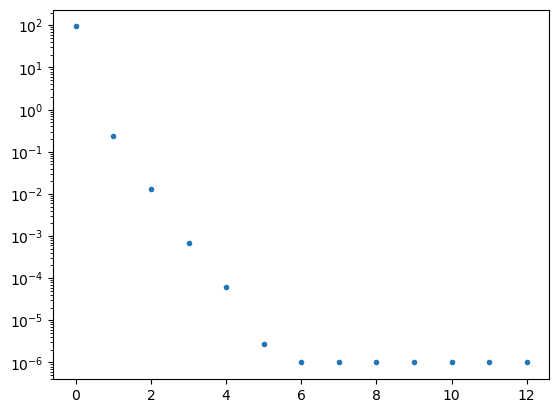

In [9]:

import matplotlib.pyplot as plt

plt.plot(config_dict['eigvals_sorted'], '.')
plt.yscale('log')